In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

data_x = pd.read_parquet("data_x1.parquet").iloc[:,1:]
data_y = pd.read_parquet("data_y1.parquet").iloc[:,1:]
data_x = torch.tensor(np.array(data_x), dtype=torch.float32)
data_y = torch.tensor(np.array(data_y), dtype=torch.float32)

In [2]:
model = nn.Sequential(nn.Linear(30, 1024), nn.ReLU(),
                      nn.Linear(1024, 256), nn.ReLU(),
                      nn.Linear(256, 128), nn.ReLU(),
                      nn.Linear(128, 64), nn.ReLU(),
                      nn.Linear(64, 5), nn.Softmax(dim=1))
model.load_state_dict(torch.load("trained_model.bin"))

<All keys matched successfully>

In [3]:
def portfolio_sigma(y, sigma):
    return torch.matmul(torch.matmul(y.unsqueeze(1), sigma), y.unsqueeze(-1)).view(-1)

with torch.no_grad():
    data_y_hat = model(data_x[0:2000000])
    data_y_hat_add = model(data_x[2000000:4000000])

data_y_hat = torch.cat((data_y_hat, data_y_hat_add))

In [13]:
with torch.no_grad():
    act_return = torch.sum(data_y * data_x[:,:5], dim=1)
    mdl_return = torch.sum(data_y_hat * data_x[:,:5],dim=1)
    act_sigma = portfolio_sigma(data_y, data_x[:,-25:].view(-1,5,5))
    mdl_sigma = portfolio_sigma(data_y_hat, data_x[:,-25:].view(-1,5,5))

In [14]:
print("Portfolio return r2:", round(np.corrcoef(act_return, mdl_return)[0,1]**2*100,2))
print("Portfolio variance r2:", round(np.corrcoef(act_sigma, mdl_sigma)[0,1]**2*100,2))

Portfolio return r2: 97.3
Portfolio variance r2: 98.45


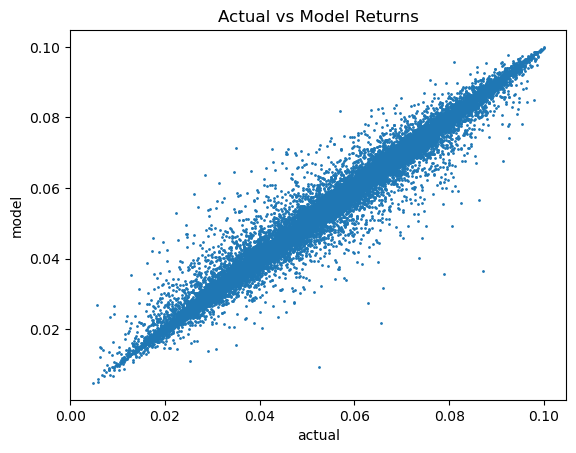

In [15]:
selection = np.random.randint(0,int(len(act_return)),size=int(len(act_return)/100))

plt.scatter(act_return[selection], mdl_return[selection], s=1)
plt.xlabel('actual')
plt.ylabel('model')
plt.title('Actual vs Model Returns')
plt.show()

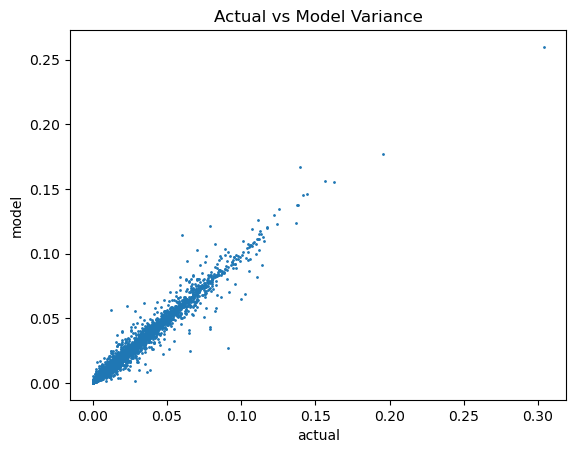

In [17]:
plt.scatter(act_sigma[selection], mdl_sigma[selection], s=1)
plt.xlabel('actual')
plt.ylabel('model')
plt.title('Actual vs Model Variance')
plt.show()